# Transformation equivariance loss
> An unsupervised constraint for better learning pixel-level labels

- toc: true
- badges: true
- comments: true
- author: Olga Moskvyak
- categories: [unsupervised, losses]
- image: images/tf_equivariance_idea.png

# Introduction

**Transformation equivariance (TE)** loss is an unsupervised constraint for learning pixel-level labels in segmentation, keypoint localization or parts detection tasks. 

A function $F$ is called **equivariant** with respect to the transformation $T$  if $ F(T(x)) = T(F(x))$. In other words, applying a transformation to $x$ is equivalent to applying it to the result  $F(x)$.

Transformation equivariant loss ensures that the output of the model changes the same way as the input under spatial transformations.
For example, if the input image is rotated by 25 degrees then it is logical to expect that the output segmentation map should change consistently:

![](my_icons/tf_equivariance_idea.png)

TE loss enforces a commutative property on a model and augmentation operations that include spatial transformation (e.g, rotations and translations), meaning that the order of applying these two operations does not matter. In other words, TE loss penalizes the difference between output of the model on the transformed image and a transformed model's output of the original image:

![](my_icons/tf_equivariance.png)

> Important: TE loss is useful in unsupervised or self-supervised settings (without ground truth labels) or semi-supervised settings (ground truth labels are available for a subset of the training data). In case of supervised training (ground truth annotations are available for the whole training set), the model attains transformation equivariance via data augmentation. 

# Formula

Let us denote $F$ - a model, $T$ – a spatial transformation, $x$ – an input image, $D$ - an error function in the image space. 
Function $D$ depends on the application and can be a mean squared error or a [perceptual loss](https://deepai.org/machine-learning-glossary-and-terms/perceptual-loss-function).
**Transformation Equivariance (TE)** loss is formulated as follows: 

$$
L_{TE}(x) = D\big(F(T(x)) - T(F(x))\big)
$$

> Note: After applying a transformation, some landmarks may go outside of the image boundary, and cause the visibility issue. This problem is alleviated in our formulation by applying the same transformation to an image. 
This is different from equivariant landmark transformation (ELT) loss proposed by [Honari et al. (2018)](https://arxiv.org/pdf/1709.01591.pdf) which computes an inverse transformation instead. In essence, inverse transformation cannot bring these landmarks back meaning that inverse transformation does not output the original image. Our approach avoids this issue.

# Differentiable transformations

Optimization of TE loss in the formula above requires to **backpropagate through the transformation**. 
While image transformations are provided in many augmentation pipelines such as [Pytorch Torchvision transforms](https://pytorch.org/vision/stable/transforms.html), [Keras image data preprocessing](https://keras.io/api/preprocessing/image/), [imgaug](https://github.com/aleju/imgaug) and [OpenCV](https://opencv.org/), these transformations do not support differentiation. 

Fortunately, a new library [**Kornia**](https://kornia.readthedocs.io/en/latest/index.html) comes to the resque to implement differentiable image transformations.
Kornia replicates OpenCV functions on tensors and allows differentiation. 

> -- <cite>Inspired by OpenCV, this library is composed by a subset of packages containing operators that can be inserted within neural networks to train models to perform image transformations, ... that operate directly on tensors. </cite>

# Implementation

Let's look at the implementation of the TE loss with PyTorch and Kornia:

In [1]:
#hide
!pip install torch==1.6
!pip install torchvision==0.7
!pip install kornia==0.4

In [2]:
import torch
import torch.nn as nn
import kornia
from kornia.geometry.transform import Resize
import random

Let's define a class for TE loss. 

Parameter `tf_matrices` is a tensor of transformation matrices generated for a batch with the method `set_tf_matrices`. The shape of the `tf_matrices` tensor depends on the type of the transformation, e.g., shape (batch_size, 2, 3) for rotations, (batch_size, 3, 3) for perspective transformations. One transformation matix is generated per an image in the batch. The same transformation is applied to the input image $x$ and the model's output $F(x)$.

Method `transform` applies transformations with the matrices `tf_matrices`.
The same transformation matrices can be applied to the input image and output of the model only if the spatial dimensions (heights and width) are the same. However, in practice, an output of the model is smaller than the input.
If dimensions of the input and the output are different, our implementation uses `Resize` method with  bilinear interpolation from Kornia to resize the output of the model to match the input size before the loss computation.
For more control in resizing, it is recommended to include upscale/downscale layers to the model.

Method `forward` computes the loss on `tfx` - a transformed model's output and `ftx` - a model's output on the transformed input.

In [8]:
#collapse_show
class TfEquivarianceLoss(nn.Module):
    """ Transformation Equivariance (TE) Loss.

    TE loss penalizes the difference between output of the model on the
    transformed image and a transformed model's output of the original image.
    TE loss utilizes differentiable transformations from Kornia library.

    Input:
        transform_type (str): type of transformation.
            Implemented types: ['rotation'].
            Default: 'rotation'
        consistency_type (str): difference function in the image space.
            Implemented types : ['mse']'
            Default: 'mse'
        batch_size (int): expected size of the batch. Default: 32.
        max_angle (int): maximum angle of rotation for rotation transformation.
            Default: 90.
        input_hw (tuple of int): image size (height, width).
            Default: (256, 128).
    """
    def __init__(self,
                 transform_type='rotation',
                 consistency_type='mse',
                 batch_size=32,
                 max_angle=90,
                 input_hw=(256, 128),
                 ):
        super(TfEquivarianceLoss, self).__init__()
        self.transform_type = transform_type
        self.batch_size = batch_size
        self.max_angle = max_angle
        self.input_hw = input_hw

        if consistency_type == 'mse':
            self.consistency = nn.MSELoss()
        elif consistency_type == 'bse':
            self.consistency = nn.BSELoss()
        else:
            raise ValueError('Incorrect consistency_type {}'.
                             format(consistency_type))

        self.tf_matrices = None

    def set_tf_matrices(self):
        """ Set transformation matrices
        """
        if self.transform_type == 'rotation':
            self.tf_matrices = self._get_rotation()

    def _get_rotation(self):
        """ Get transformation matrices

        Output:
            rot_mat (float torch.Tensor): tensor of shape (batch_size, 2, 3)
        """
        # define the rotation center
        center = torch.ones(self.batch_size, 2)
        center[..., 0] = self.input_hw[1] / 2  # x
        center[..., 1] = self.input_hw[0] / 2  # y

        # create transformation (rotation)
        angle = torch.tensor(
            [random.randint(-self.max_angle, self.max_angle)
             for _ in range(self.batch_size)]
        )
        # define the scale factor
        scale = torch.ones(self.batch_size)

        # compute the transformation matrix
        tf_matrices = kornia.get_rotation_matrix2d(center, angle, scale)
        return tf_matrices

    def transform(self, x):
        """ Transform input with transformation matrices
        Input:
            x (float torch.Tensor): input data of shape (batch_size, ch, h, w)

        Output:
            xf_x (float torch.Tensor): transformed data
                of shape (batch_size, ch, h, w)

        If transformation input is different from the input size defined
        in the construction then resize the input before transformation.
        Input size is important because transformation matrices depend on
        the image size, e.g the center of rotation.
        """
        resize_input = False

        # Check input size
        if x.shape[2:] != self.input_hw:
            curr_hw = x.shape[2:]
            x = Resize(self.input_hw)(x)
            resize_input = True

        # Transform image
        tf_x = kornia.warp_affine(
            x.float(),
            self.tf_matrices,
            dsize=self.input_hw)

        # Transform back if image has been resized
        if resize_input:
            tf_x = Resize(curr_hw)(tf_x)
        return tf_x

    def forward(self, tfx, ftx):
        loss = self.consistency(tfx, ftx)
        return loss

Now let's see how TE loss is computed on three examples.

# Examples

## 1: Dummy data on 1-layer CNN model

The first example is on dummy data and 1-layer convolutional model:

In [9]:
x = torch.randn((4, 3, 64, 64))

The demo model is a one layer model with three convolutional 1x1 filters (no bias) which is just a weighted combination of RGB layers of a colour image. 
The model satisfies transformation equivariance constraint just by its design.
Let us check that the loss is zero.

In [10]:
model = nn.Sequential(nn.Conv2d(3, 1, 1, bias=False))
model

Sequential(
  (0): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
)

Initialise Transformation Equivariance loss. This example implements rotation transformation $T$ with a mean squared error as the function $D$.

In [11]:
tf_equiv_loss = TfEquivarianceLoss(
    transform_type='rotation',
    consistency_type='mse',
    batch_size=4,
    max_angle=45,
    input_hw=(64, 64)
)

Compute loss on a batch of data $x$:

In [12]:
# Generate a transformation
tf_equiv_loss.set_tf_matrices()

# Compute model on input image
fx = model(x)

# Transform output
tfx = tf_equiv_loss.transform(fx)

# Transform input image
tx = tf_equiv_loss.transform(x)

# Compute model on the transformed image
ftx = model(tx)

loss = tf_equiv_loss(tfx, ftx)
loss.item()

8.614403424123855e-16

The computed loss is close to zero as expected for this kind of model.

## 2: Real data on 1-layer CNN model

Second example uses images from a subset of [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) dataset (we select the smallest subset for demonstration purposes).

Data preparation in this example is a bit longer than for dummy data. Images are resized, converted to tensors and normalized. Segmentation maps are available for this dataset but they are not used for loss computations in our example (we still need to preprocess them to get torch tensors for data loader).

In [16]:
from torchvision.datasets import VOCSegmentation

In [17]:
import torchvision.transforms as T
image_tf = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
               )
])

segm_tf = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

In [18]:
# Load the smallest subset of VOC segmentation dataset
dataset = VOCSegmentation(
    root='../',
    year='2007',
    image_set='test',
    download=True,
    transform=image_tf, 
    target_transform=segm_tf,
    transforms=None,
    )

Using downloaded and verified file: ../VOCtest_06-Nov-2007.tar


In [19]:
# Define data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=4, 
    shuffle=True, 
    num_workers=4,
)
data_loader_iter = iter(data_loader)

In [20]:
# Initialize model and train on the GPU or on the CPU, if a GPU is not available
model = nn.Sequential(nn.Conv2d(3, 1, 1, bias=False))
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

Sequential(
  (0): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
)

In [21]:
# Get one batch and compute loss
data_batch = next(data_loader_iter)
# Take only images and discard annotations
x = data_batch[0]

Note that we are not using ground truth annotation for computing loss in this example

In [22]:
# Generate a transformation
tf_equiv_loss.set_tf_matrices()

# Compute model on input image
fx = model(x)

# Transform output
tfx = tf_equiv_loss.transform(fx)

# Transform input image
tx = tf_equiv_loss.transform(x)

# Compute model on the transformed image
ftx = model(tx)

loss = tf_equiv_loss(tfx, ftx)
loss.item()

2.867537716338183e-15

In [23]:
#hide
import matplotlib.pyplot as plt

%matplotlib inline

Lets plot input and rotated images and corresponding output model to check that our test model satisfies transformation equivariance constraint (consistent with rotation transformations).
We can see that output of the model changes consistently with the image changes.

In [24]:
#collapse
def unnormalize(batch_image,
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                use_gpu=False):
    """Reverse normalization applied to image by transformations
    """
    B = batch_image.shape[0]
    H = batch_image.shape[2]
    W = batch_image.shape[3]
    t_mean = torch.FloatTensor(mean).view(3, 1, 1).\
        expand(3, H, W).contiguous().view(1, 3, H, W)
    t_std = torch.FloatTensor(std).view(3, 1, 1).\
        expand(3, H, W).contiguous().view(1, 3, H, W)
    if use_gpu:
        t_mean = t_mean.cuda()
        t_std = t_std.cuda()
    batch_image_unnorm = batch_image * t_std.expand(B, 3, H, W) + \
        t_mean.expand(B, 3, H, W)
    return batch_image_unnorm

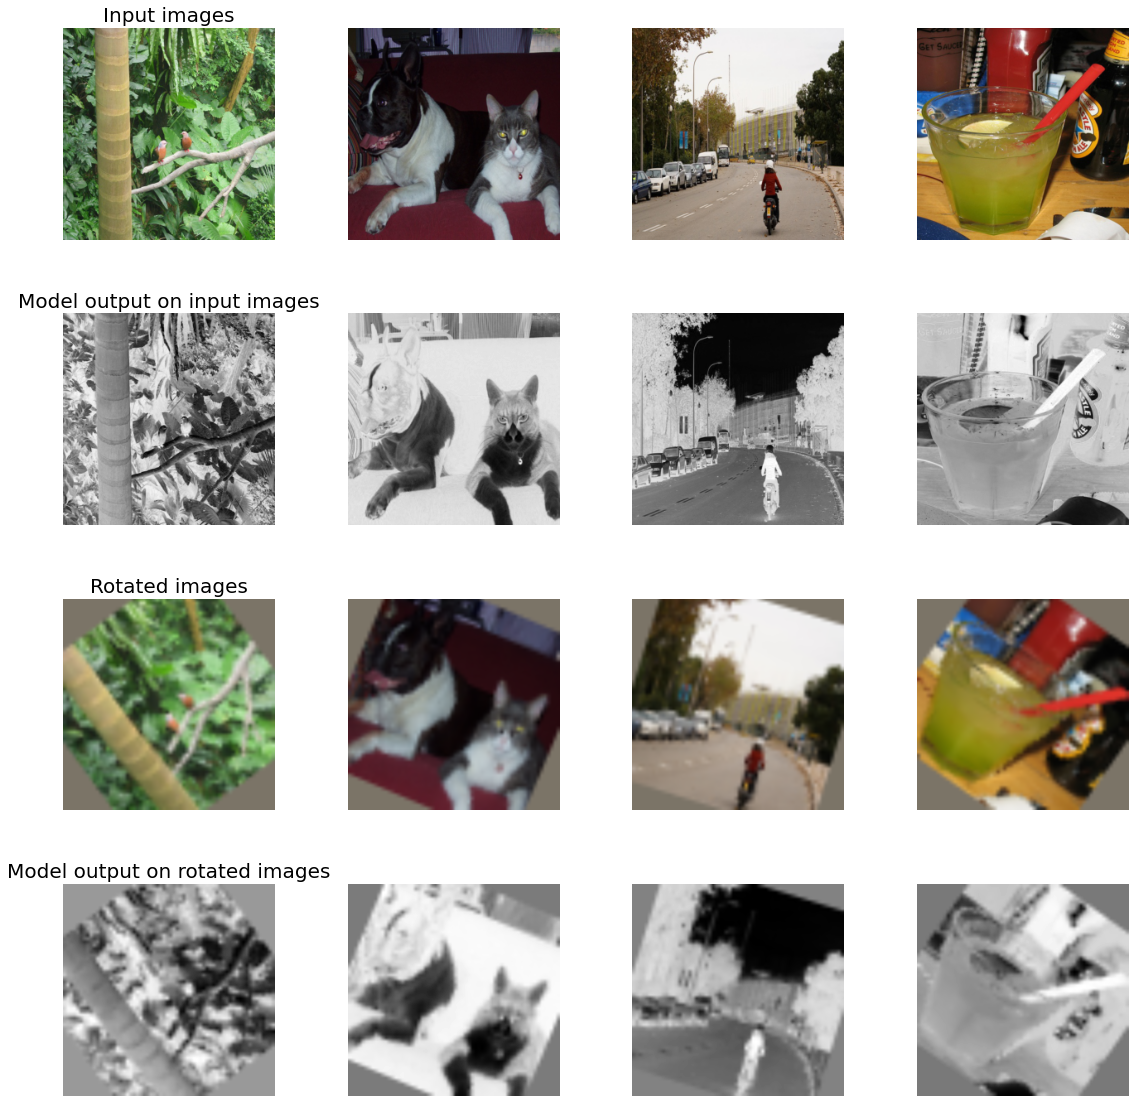

In [25]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))

# Convert tensors to numpy, transpose channels and reverse normalization for display purposes
x_display = unnormalize(x).numpy().transpose(0, 2, 3, 1)
tx_display = unnormalize(tx).numpy().transpose(0, 2, 3, 1)
fx_display = fx.squeeze().detach().cpu().numpy()
ftx_display = ftx.squeeze().detach().cpu().numpy()

for i in range(4):
    ax[0, i].imshow(x_display[i])
    ax[0, i].axis('off')
    
    ax[1, i].imshow(fx_display[i], cmap='gray')
    ax[1, i].axis('off')
    
    ax[2, i].imshow(tx_display[i])
    ax[2, i].axis('off')
    
    ax[3, i].imshow(ftx_display[i], cmap='gray')
    ax[3, i].axis('off')
    
ax[0, 0].set_title('Input images', fontsize=20)
ax[1, 0].set_title('Model output on input images', fontsize=20)
ax[2, 0].set_title('Rotated images', fontsize=20)
ax[3, 0].set_title('Model output on rotated images', fontsize=20)
plt.tight_layout()

As we see the loss is zero and the output of the model changes consistently when the input changes.

## 3: Real data on pre-trained segmentation model

Data has been loaded in the previous example.
We only need to download pre-trained segmentation model from torchvision library.

In [26]:
import torchvision
import numpy as np

In [27]:
#collapse-output
model = torchvision.models.segmentation.fcn_resnet50(
    pretrained=True, progress=True, num_classes=21, aux_loss=None
)
model.to(device)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

Define loss function:

In [28]:
tf_equiv_loss = TfEquivarianceLoss(
    transform_type='rotation',
    consistency_type='mse',
    batch_size=4,
    max_angle=45,
    input_hw=(256, 256)
)

In [29]:
data_batch = next(data_loader_iter)
x = data_batch[0]

In [30]:
# Generate a transformation
tf_equiv_loss.set_tf_matrices()

# Compute model on input image
fx = model(x)['out']

# Transform output
tfx = tf_equiv_loss.transform(fx)

# Transform input image
tx = tf_equiv_loss.transform(x)

# Compute model on the transformed image
ftx = model(tx)['out']

loss = tf_equiv_loss(tfx, ftx)
loss.item()

3.0543460845947266

The loss in this example is far from zero. Let's visualize all inputs and outputs to verify that the model is not consistent for rotation transformations.

The folowing code defines the helper function to color segmentations for each class and display it in one color image: 

In [31]:
#collapse
def decode_segmap(image, nc=21):
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
  
    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
    
    rgb = np.stack([r, g, b], axis=2)
    return rgb

Segmentation model inputs 21 channels for each image (one segmentation map for each class and one background map).
We use [helper function](https://learnopencv.com/pytorch-for-beginners-semantic-segmentation-using-torchvision/) to decode segmentation maps.

WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


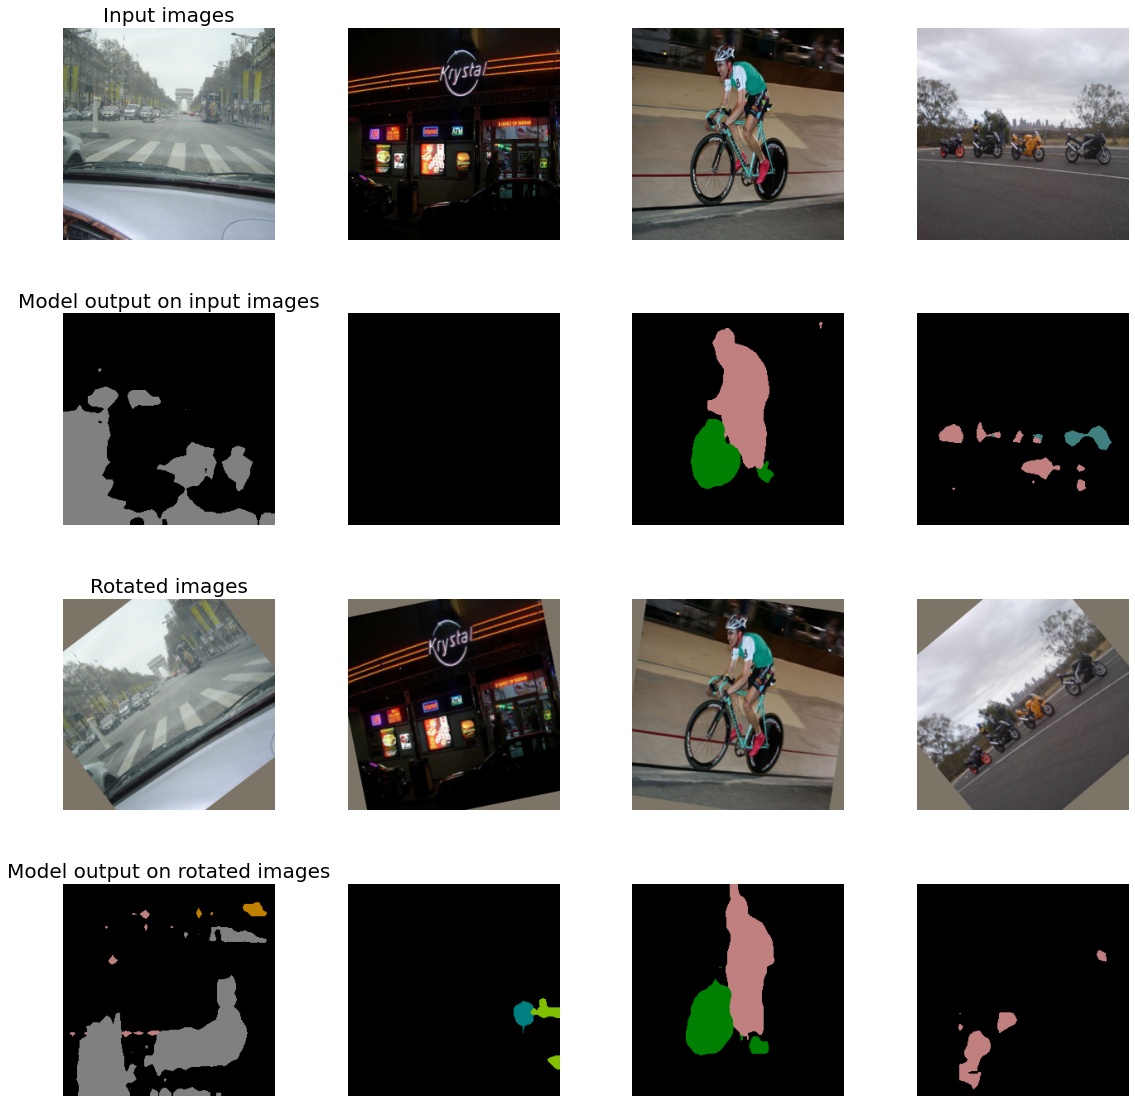

In [32]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))

# Convert tensors to numpy, transpose channels and reverse normalization for display purposes
x_display = unnormalize(x).numpy().transpose(0, 2, 3, 1)
tx_display = unnormalize(tx).numpy().transpose(0, 2, 3, 1)
# fx_display = fx.squeeze().detach().cpu().numpy()
fx_display = torch.argmax(fx.squeeze(), dim=1).detach().cpu().numpy()
# ftx_display = ftx.squeeze().detach().cpu().numpy()
ftx_display = torch.argmax(ftx.squeeze(), dim=1).detach().cpu().numpy()

for i in range(4):
    ax[0, i].imshow(x_display[i])
    ax[0, i].axis('off')
    
    ax[1, i].imshow(decode_segmap(fx_display[i]), cmap='gray')
    ax[1, i].axis('off')
    
    ax[2, i].imshow(tx_display[i])
    ax[2, i].axis('off')
    
    ax[3, i].imshow(decode_segmap(ftx_display[i]), cmap='gray')
    ax[3, i].axis('off')
    
ax[0, 0].set_title('Input images', fontsize=20)
ax[1, 0].set_title('Model output on input images', fontsize=20)
ax[2, 0].set_title('Rotated images', fontsize=20)
ax[3, 0].set_title('Model output on rotated images', fontsize=20)
plt.tight_layout()

The example shows that the loss value on the batch is greater than zero and printed results confirm that the current model is not transformation equivariant.